In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import scipy.ndimage as img

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from skimage import data, io, filters
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage.color import rgb2gray, rgb2hsv
from skimage.feature import hog
import skimage

from skorch_utils import (MLP, LRScheduler, SaveWeights, EarlyStopping, 
    NaNStopping, learning_curve)
from skorch.callbacks import Checkpoint
from LDMM import LDMNetSkorch, SaveLDMNetVars
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
random_seed = 0
path = './Data/fotos_sumatra'

In [3]:
def crop_resize(image, size=64):
    height, width, ch = image.shape
    ratio = image.shape[0]/image.shape[1] 
    if ratio > 1.0:
        ratio = 1.0/ratio
    if ratio < 0.9:
        offset = np.abs(width-height)//2
        if height < width:
            image = image[:,offset:-offset, :]
        else:
            image = image[offset:-offset, :, :]
    image = skimage.transform.resize(image, (size, size, ch))
    return image

In [4]:
X_inceptionV3 = np.load(os.path.join(path,'features_inceptionV3.npy'))
files = np.loadtxt(os.path.join(path,'images_inceptionV3.txt'), dtype=str, 
                    delimiter='\n')
images = np.stack([crop_resize(io.imread(f)) for f in files], axis=0)
y = np.array([1 if f.find('SANS') > -1 else 0 for f in files])

/mnt/Data/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [5]:


X = X_inceptionV3
X_imgs = images
X.shape, X_imgs.shape, y.shape

((69, 2048), (69, 64, 64, 3), (69,))

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
skf = StratifiedShuffleSplit(n_splits=1, test_size=0.2,
                              random_state=random_seed)
train, test = next(skf.split(X,y))

In [7]:
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)
module = MLP(n_in=X.shape[1], num_units=(100), n_out=2, drop_proba=0)
model = LDMNetSkorch(
    module,
    layer_name='hidden1',
    batch_size=X.shape[0],
    max_epochs=300,
    lr=0.0005,
    mu=1e-4,
    lambda_bar=0.001,
    device='cuda',
    verbose=1,
    callbacks=[
        Checkpoint(os.path.join(path, 'best_weights.pt')),
        EarlyStopping(50, 'valid_loss'), 
        NaNStopping(), 
        LRScheduler('ReduceLROnPlateau'), 
        SaveWeights(every_n_epochs=10),
        SaveLDMNetVars(every_n_epochs=10)]
)

In [8]:
overwrite = True
DIR = path
FILE = 'SumatraLDMNet_save.pkl'
os.makedirs(DIR, exist_ok=True)
fname = os.path.join(DIR, FILE)
if not os.path.exists(fname) or overwrite:
    model.fit(X, y, X_imgs.reshape(X_imgs.shape[0],-1))
    model.load_params(os.path.join(path, 'best_weights.pt'))
    pd.to_pickle({'model': model}, fname)
else:
    print('Loading...')
    saved = pd.read_pickle(fname)
    model = saved['model']


Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6987       0.5714        0.6924  0.0057
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
      2        0.6981       0.5714        0.6920  0.0045
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
      3        0.6974       0.5714        0.6917  0.0032
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
      4        0.6967       0.5714        0.6914  0.0040
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
      5        0.6961       0.5714        0.6911  0.0035
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
      6        0.6954       0.5714        0.6908  0.0045
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
      7        0.6947       0.5714        0.6906  0.0034
Checkpoint! Saving model 

Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
     59        0.6658       0.6429        0.6762  0.0034
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
     60        0.6654       0.6429        0.6759  0.0042
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
     61        0.6649       0.6429        0.6757  0.0044
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
     62        0.6644       0.6429        0.6755  0.0058
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
     63        0.6640       0.6429        0.6752  0.0036
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
     64        0.6635       0.6429        0.6750  0.0043
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
     65        0.6631       0.6429        0.6748  0.0070
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
     66        0.6626       0.6429        0.6745  0.0057
Checkpoint! Savi

Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    118        0.6399       0.7857        0.6630  0.0039
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    119        0.6395       0.7857        0.6628  0.0046
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    120        0.6390       0.7857        0.6626  0.0081
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    121        0.6386       0.7857        0.6624  0.0034
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    122        0.6382       0.7857        0.6622  0.0060
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    123        0.6378       0.7857        0.6620  0.0035
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    124        0.6373       0.7857        0.6617  0.0043
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    125        0.6369       0.7857        0.6615  0.0037
Checkpoint! Savi

Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    177        0.6157       0.7857        0.6510  0.0064
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    178        0.6153       0.7857        0.6508  0.0043
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    179        0.6149       0.7857        0.6506  0.0038
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    180        0.6145       0.7857        0.6504  0.0060
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    181        0.6141       0.7857        0.6502  0.0034
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    182        0.6136       0.7857        0.6500  0.0041
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    183        0.6133       0.7857        0.6498  0.0039
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    184        0.6128       0.7857        0.6495  0.0042
Checkpoint! Savi

    235        0.5927       0.7857        0.6394  0.0033
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    236        0.5923       0.7857        0.6392  0.0043
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    237        0.5919       0.7857        0.6390  0.0037
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    238        0.5915       0.7857        0.6388  0.0048
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    239        0.5911       0.7857        0.6386  0.0033
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    240        0.5907       0.7857        0.6384  0.0043
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    241        0.5903       0.7857        0.6383  0.0034
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    242        0.5899       0.7857        0.6381  0.0049
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    243        0

Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    294        0.5695       0.8571        0.6279  0.0066
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    295        0.5691       0.8571        0.6277  0.0035
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    296        0.5687       0.8571        0.6275  0.0047
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    297        0.5683       0.8571        0.6274  0.0034
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    298        0.5679       0.8571        0.6271  0.0039
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    299        0.5676       0.8571        0.6270  0.0032
Checkpoint! Saving model to ./Data/fotos_sumatra/best_weights.pt.
    300        0.5672       0.8571        0.6268  0.0045


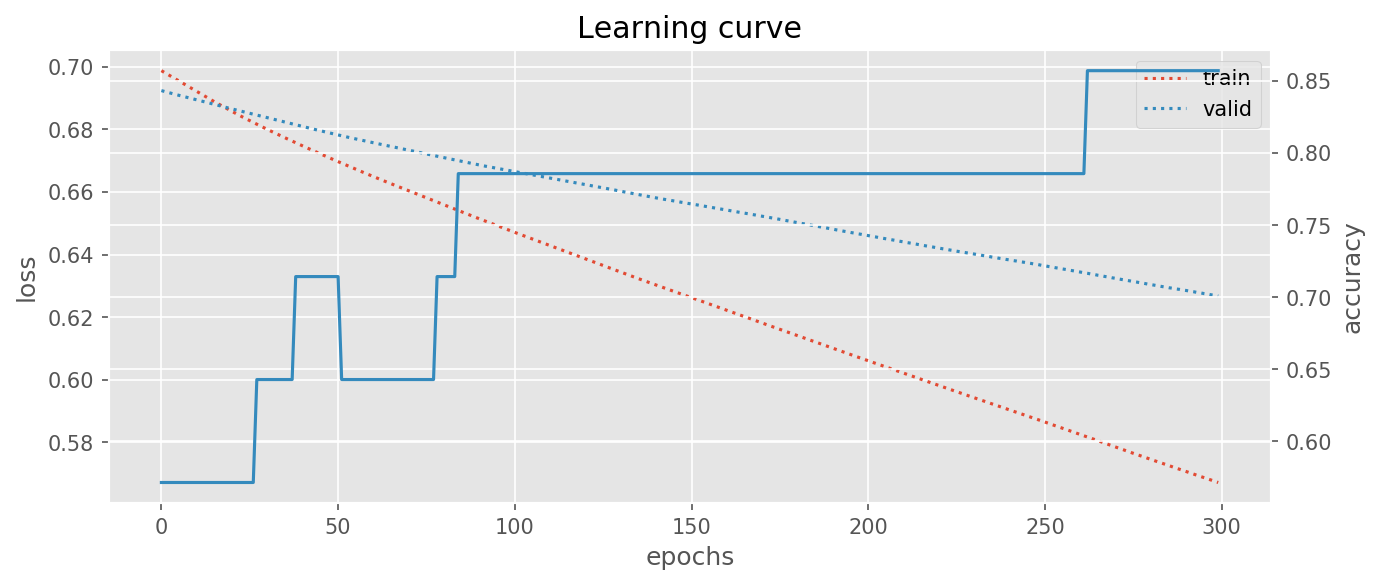

In [22]:
with matplotlib.style.context('ggplot'):
    learning_curve(model)
    plt.gcf().set_dpi(150)
    plt.gcf().set_size_inches(10,4)

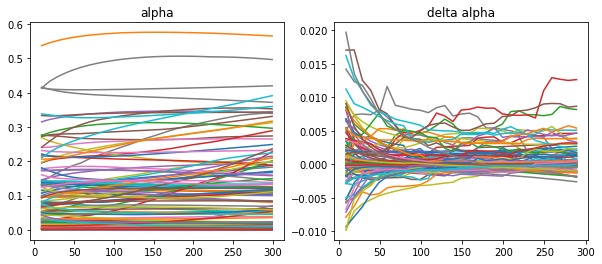

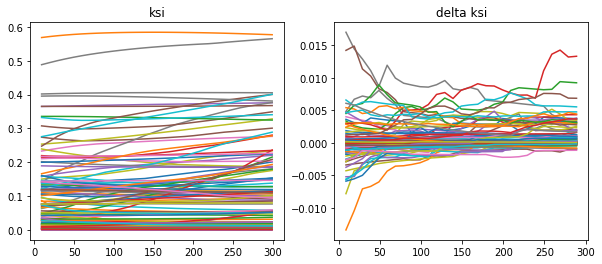

In [10]:
%run LDMM_plot_utils.py

plot_ldmm_vars(model, 'alpha')
plot_ldmm_vars(model, 'ksi')

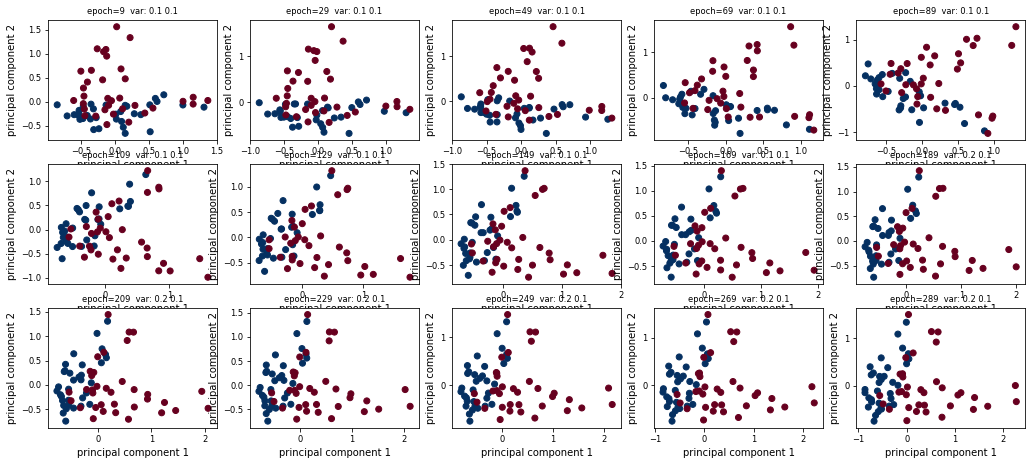

In [11]:
plt.rcParams['image.cmap'] = 'RdBu'
_=plot_over_time(model, 'ksi', every_n=2, y=y)

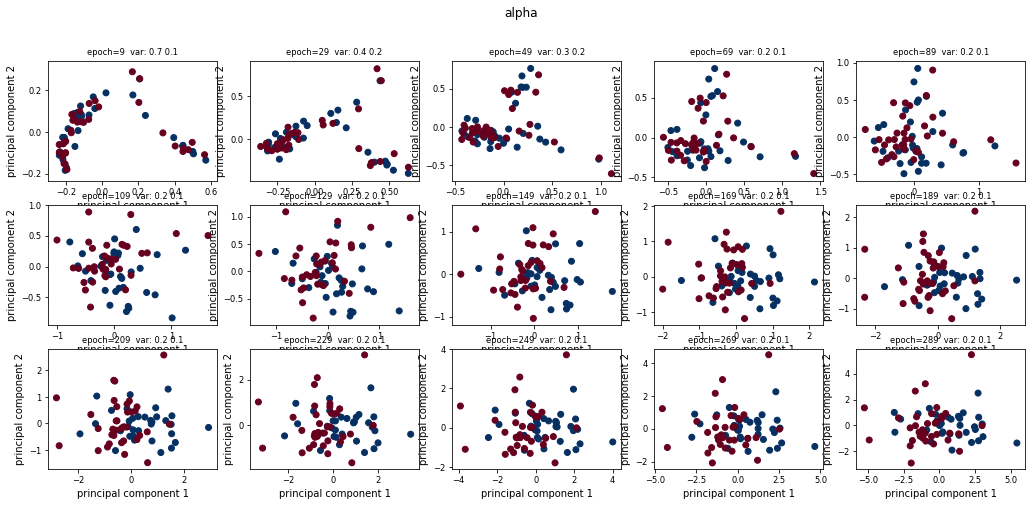

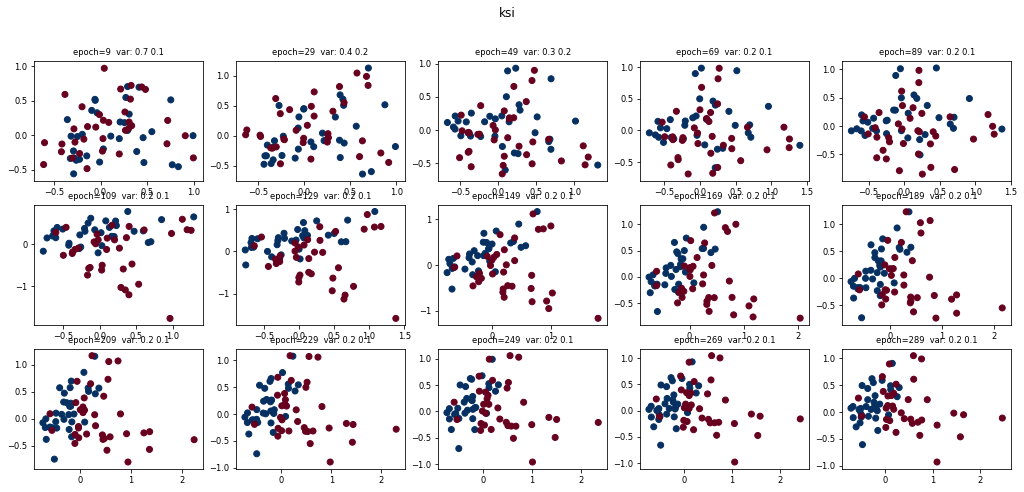

In [12]:
plot_ksi_alpha_time(model, every_n=2, y=y)